In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Make the pandas dataframe for train and test

In [2]:
train_dir_real = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/real_train"

file_paths_real = []
    
for filename in os.listdir(train_dir_real):
    file_paths_real.append(os.path.join(train_dir_real, filename))

In [3]:
labels_real = 800 * [0]

In [4]:
df_train_real = pd.DataFrame({'filename': file_paths_real, 'label': labels_real})

In [5]:
train_dir_fake = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/train_images/train_images/fake_train"

file_paths_fake = []
    
for filename in os.listdir(train_dir_fake):
    file_paths_fake.append(os.path.join(train_dir_fake, filename))

In [6]:
labels_fake = 800 * [1]

In [7]:
df_train_fake = pd.DataFrame({'filename': file_paths_fake, 'label': labels_fake})

In [8]:
df_train = pd.concat([df_train_real, df_train_fake], ignore_index=True)

In [9]:
df_train.head()

,filename,label
0,/kaggle/input/wec-intelligence-sig-2024-recrui...,0
1,/kaggle/input/wec-intelligence-sig-2024-recrui...,0
2,/kaggle/input/wec-intelligence-sig-2024-recrui...,0
3,/kaggle/input/wec-intelligence-sig-2024-recrui...,0
4,/kaggle/input/wec-intelligence-sig-2024-recrui...,0


Shuffle the dataframe

In [10]:
df_train_new = df_train.sample(frac=1).reset_index(drop=True)

In [12]:
def read_image_pillow(file_path):
    return Image.open(file_path)

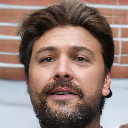

In [13]:
image_path = df_train_new['filename'].iloc[0]
image = read_image_pillow(image_path)
image

In [14]:
transform = transforms.ToTensor()

def image_to_tensor(file_path):
    image = Image.open(file_path)
    image_tensor = transform(image)
    return image_tensor

In [15]:
image_path = df_train_new['filename'].iloc[0]
image_tensor = image_to_tensor(image_path)
print(image_tensor.shape)

torch.Size([3, 128, 128])


**ResNet model**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc(x))
        return x


#We create the model with 18 layers here

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


MobileNet model

In [17]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

In [18]:
class MobileNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor):
        super(MobileNetBlock, self).__init__()
        self.stride = stride
        self.use_residual = (in_channels == out_channels) and (stride == 1)
        hidden_dim = in_channels * expansion_factor

        self.conv = nn.Sequential(
            # Pointwise block
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Depthwise block
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            # Pointwise-linear block
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [19]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super(MobileNetV2, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            
            self._make_layer(32, 16, 1, 1, 1),  
            self._make_layer(16, 24, 6, 2, 2),  
            self._make_layer(24, 32, 6, 3, 2),  
            self._make_layer(32, 64, 6, 4, 2),  
            self._make_layer(64, 96, 6, 3, 1),  
            self._make_layer(96, 160, 6, 3, 2), 
            self._make_layer(160, 320, 6, 1, 1), 
            
            
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )
        
        self.pool = nn.AdaptiveAvgPool2d(1)  
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 1) 
        )

    def _make_layer(self, in_channels, out_channels, expansion_factor, n, stride):
        layers = []
        for i in range(n):
            s = stride if i == 0 else 1
            layers.append(MobileNetBlock(in_channels, out_channels, s, expansion_factor))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x) 
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x 

In [20]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

Image augmentation

In [21]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Define the hyperparameters

I have experimented with both ResNet and MobileNet, and what I have found is that for MobileNet the learning rate is the best at 0.001, however for ResNet its best when the rate is 0.0008. This can be due to the fact that ResNet has ~11M params while MobileNet has 2M params.

You can experiment with different learning rates

In [ ]:
batch_size = 32
lr = 0.0008

In [55]:
train_dataset = CustomImageDataset(df_train_new, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = ResNet18()

x = torch.randn(8, 3, 128, 128)
output = model(x)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000

print(f"Total number of parameters: {num_params}")
print(output.shape)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Total number of parameters: 11.177025
torch.Size([8, 1])


In [56]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    train_loader = tqdm(train_loader, desc="Training", leave=False)

    for i, (images, labels) in enumerate(train_loader):
        labels = labels.view(-1, 1).float()
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted=(outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_loader.set_postfix(loss=running_loss / total, accuracy=100 * correct / total)

    print(f"Training Loss: {running_loss / total:.4f}, Accuracy: {100 * correct / total:.2f}%")


In [26]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train(model, train_loader, criterion, optimizer)

Epoch 1/10


Training Loss: 0.7171, Accuracy: 52.44%
Epoch 2/10


Training Loss: 0.6779, Accuracy: 55.88%
Epoch 3/10


Training Loss: 0.6542, Accuracy: 58.44%
Epoch 4/10


Training Loss: 0.5991, Accuracy: 67.12%
Epoch 5/10


Training Loss: 0.4911, Accuracy: 74.38%
Epoch 6/10


Training Loss: 0.3172, Accuracy: 85.81%
Epoch 7/10


Training Loss: 0.2039, Accuracy: 91.31%
Epoch 8/10


Training Loss: 0.1209, Accuracy: 95.38%
Epoch 9/10


Training Loss: 0.1070, Accuracy: 95.56%
Epoch 10/10


Training Loss: 0.0789, Accuracy: 97.12%


Testing the model on test dataset

In [28]:
image_path = "/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images/test_image_105.jpg"
image = Image.open(image_path).convert("RGB")


image = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image)
    
probability = torch.sigmoid(output)
probability.item()

0.7264028191566467

In [47]:
test_images_path = '/kaggle/input/wec-intelligence-sig-2024-recruitment-task-cv/test_images/test_images'

test_images_results = []

transs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for filename in os.listdir(test_images_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):

        image_path = os.path.join(test_images_path, filename)
        image = Image.open(image_path).convert('RGB')
        
        image = transs(image).unsqueeze(0) 

        model.eval()
        with torch.no_grad():
            output = model(image) 

        probability = torch.sigmoid(output)
        probs = probability.item()
        
        result = (probs >= 0.5)
        test_images_results.append(result)

print(test_images_results)

[True, False, True, False, False, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, True, False, False, True, False, True, True, False, True, False, True, False, False, True, True, False, False, True, False, True, False, True, False, True, True, False, False, False, False, True, False, True, False, False, False, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, True, False, True, False, False, False, False, False, True, False, False, True, True, True, False, False, True, False, True, False, False, False, False, False, True, False, True, True, True, True, False, False, True, False, False, False, True, True, False, False, False, False, True, True, False, False, False, True, True, False, False, True, True, False, True, False, True, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, True, True, False, False, Fa

In [54]:
import csv
csv_file_path = '/kaggle/working/results.csv'

with open(csv_file_path, mode='w', newline='') as csv_file:

    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'Value'])
    
    for index, value in enumerate(test_images_results):
        if value==True:
            value = 1
        else:
            value = 0
        writer.writerow([index+1, value])

print(f'Data successfully written to {csv_file_path}')


Data successfully written to /kaggle/working/results.csv


In [48]:
real = 0
fake = 0

for i in test_images_results:
    if(i):
        fake+=1
    else:
        real+=1

In [49]:
print(real)
print(fake)

257
143
